Read CSV data with Pandas.

In [17]:
import pandas as pd
import numpy as np

# team stats
team_summaries = pd.read_csv('nba_data/stats_archive/Team Summaries.csv')
# team_totals = pd.read_csv('nba_data/stats_archive/Team Totals.csv')
team_per100 = pd.read_csv('nba_data/stats_archive/Team Stats Per 100 Poss.csv')

# player stats
# player_totals = pd.read_csv('nba_data/stats_archive/Player Totals.csv')
player_shooting = pd.read_csv('nba_data/stats_archive/Player Shooting.csv')
player_play_by_play = pd.read_csv('nba_data/stats_archive/Player Play By Play.csv')
player_per100 = pd.read_csv('nba_data/stats_archive/Per 100 Poss.csv')

# games
games = pd.read_csv('nba_data/game_archive/games.csv')
teamids = pd.read_csv('nba_data/game_archive/teams.csv')


Remove unnecessary features.

In [18]:
# games
teamids['TEAM_NAME'] = teamids['CITY'] + ' ' + teamids['NICKNAME']
teamids = teamids[['TEAM_ID','TEAM_NAME','ABBREVIATION']]

games = games[['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS','PTS_home','PTS_away']]

In [19]:
# team stats
team_stats = team_summaries.merge(team_per100)
team_stats.drop(columns=['playoffs','arena','attend','lg'], inplace=True)

# player stats
player_stats = player_shooting.merge(player_play_by_play).merge(player_per100)
player_stats.drop(columns=['birth_year','pos','lg'], inplace=True)

Create player efficiency indices.

𝐼NBA=𝑁pts+𝑁rbs+𝑁asts+𝑁stls+𝑁blcks−(𝑁msFld+𝑁msFT+𝑁tos)

In [20]:
player_stats['player_eff_ind'] = (player_stats['pts_per_100_poss'] +
                           player_stats['trb_per_100_poss'] +
                           player_stats['ast_per_100_poss'] +
                           player_stats['stl_per_100_poss'] +
                           player_stats['blk_per_100_poss'] -
                           (player_stats['tov_per_100_poss'] +
                            player_stats['fga_per_100_poss'] - player_stats['fg_per_100_poss'] +
                            player_stats['fta_per_100_poss'] - player_stats['ft_per_100_poss']))
# player_stats

Create team efficiency indices.

In [21]:
#create the team efficeny index by summing the players by season and team 
team_eff_ind = player_stats.groupby(['tm', 'season'])['player_eff_ind'].sum().reset_index(name='team_eff_ind')
team_eff_ind.rename(columns = {'tm':'abbreviation'}, inplace = True)

In [22]:
#merging the team efficeny index to team_stats
team_stats = team_stats.merge(team_eff_ind)
# team_stats

To each game, append home and away team stats in the respective season.

In [23]:
# add team_id to team stats
teamids.rename(columns = {'ABBREVIATION':'abbreviation','TEAM_NAME':'team'}, inplace = True)
team_stats = team_stats.merge(teamids)
team_stats.drop(columns=['team','abbreviation'], inplace = True)

In [24]:
min(team_stats.season)

1997

In [47]:
# add home team stats to games
h_team_stats = team_stats.add_prefix('h_')
final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_season'])
final_df.drop(columns=['h_season','h_TEAM_ID'], inplace = True)

# add away team stats to games
a_team_stats = team_stats.add_prefix('a_')
final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_season'])
final_df.drop(columns=['a_season','a_TEAM_ID'], inplace = True)

In [48]:
# sort games by date, ascending
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])
final_df = final_df.sort_values(by='GAME_DATE_EST', ascending=True).reset_index(drop=True)

Add novel features from the parent paper.

In [49]:
# import warnings
# warnings.filterwarnings("ignore")

# final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

# # Create a combined identifier for each game's home and away team for vectorized operations
# final_df['game_team'] = final_df.apply(lambda x: f"{x['GAME_DATE_EST']}_{x['HOME_TEAM_ID']}", axis=1)
# final_df['game_opponent'] = final_df.apply(lambda x: f"{x['GAME_DATE_EST']}_{x['VISITOR_TEAM_ID']}", axis=1)

# # Create dictionaries to hold win percentages
# team_win_pct = {}

# # Function to update win percentages
# def update_win_pct(row, n=10):
#     global team_win_pct
#     game_team = row['game_team']
#     game_opponent = row['game_opponent']
    
#     # Update the team and opponent win percentages based on historical data
#     team_pct = team_win_pct.get(game_team, [0, n]) # [wins, games]
#     opponent_pct = team_win_pct.get(game_opponent, [0, n])
    
#     h_pct = team_pct[0] / team_pct[1]
#     a_pct = opponent_pct[0] / opponent_pct[1]
    
#     # Update win counts and game counts
#     if row['HOME_TEAM_WINS'] == 1:
#         team_pct[0] += 1 
#     else:
#         opponent_pct[0] += 1 
    
#     team_pct[1] = min(team_pct[1] + 1, n)
#     opponent_pct[1] = min(opponent_pct[1] + 1, n)
    
#     # Update the dictionaries
#     team_win_pct[game_team] = team_pct
#     team_win_pct[game_opponent] = opponent_pct
    
#     return h_pct, a_pct

# win_pct_columns = final_df.apply(update_win_pct, axis=1, result_type='expand')
# final_df['H_w_pct_10'] = win_pct_columns[0]
# final_df['A_w_pct_10'] = win_pct_columns[1]

# final_df[final_df['HOME_TEAM_ID']==1610612762].head(20)

import warnings
warnings.filterwarnings("ignore")

final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

def get_avg_win_pct_last_n_games(team, game_date, df, n):
    # Extract the last 10 games 
    prev_game_df = df[df['GAME_DATE_EST'] < game_date][(df['HOME_TEAM_ID'] == team) | (df['VISITOR_TEAM_ID'] == team)].tail(n)
    
    wins = 0 
    # Filter columns to include only 'Home' team and result, then divide into home and away games        
    result_df = prev_game_df
    h_df = result_df.loc[result_df['HOME_TEAM_ID'] == team] 
    
    h_wins = h_df.loc[h_df['HOME_TEAM_WINS'] == 1]
    
    wins += len(h_wins)
    
    a_df = result_df.loc[result_df['HOME_TEAM_ID'] != team]
    a_wins = a_df.loc[a_df['HOME_TEAM_WINS'] == 0]
    
    wins += len(a_wins)

    return wins/n

for index, row in final_df.iterrows() : 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    h_team = row['HOME_TEAM_ID']
    a_team = row['VISITOR_TEAM_ID']
    final_df.loc[index,'H_w_pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, final_df, 10)
    final_df.loc[index,'A_w_pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, final_df, 10)

In [50]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
# import time

final_df = final_df[final_df['PTS_away'].notna() & final_df['PTS_home'].notna()]

# Calculate win probabilities using Elo ratings and home court advantage
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Calculate odds of the home team winning based on Elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

# Determines the K factor in Elo rating updates, considering the margin of victory and Elo rating difference
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

# Update Elo ratings for both teams following a game, considering the outcome and game specifics
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo

# Define a function to retrieve a team's Elo rating before a given game, adjusting for season transitions
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['GAME_DATE_EST'] < date][(team_stats['HOME_TEAM_ID'] == team) | (team_stats['VISITOR_TEAM_ID'] == team)].tail(1).iloc[0] 

    if team == prev_game['HOME_TEAM_ID'] :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['SEASON'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# Loop through each game to update ELO ratings
for index, row in final_df.iterrows(): 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    season = row['SEASON']
    h_team, a_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    h_score, a_score = row['PTS_home'], row['PTS_away'] 
    # Set or get previous Elo ratings
    if (h_team not in elo_df['HOME_TEAM_ID'].values and h_team not in elo_df['VISITOR_TEAM_ID'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, final_df, elo_df)

    if (a_team not in elo_df['HOME_TEAM_ID'].values and a_team not in elo_df['VISITOR_TEAM_ID'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, final_df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'GAME_ID': game_id, 'HOME_TEAM_ID': h_team, 'VISITOR_TEAM_ID': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'GAME_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'HOME_TEAM_ID', 'SEASON': season}
    teams_row_two = {'GAME_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'VISITOR_TEAM_ID', 'SEASON': season}
    
    # Record Elo ratings in elo_df and teams_elo_df
    elo_df.loc[len(elo_df)] = new_row
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_one
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_two

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)
# Merge updated Elo ratings back into the main DataFrame
final_df = final_df.merge(elo_df.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID']), on ='GAME_ID')

In [53]:
# final_df.tail(20)

In [54]:
# save final df
final_df.to_csv(r'nba_data\our_df_final.csv', index = False)

In [83]:
# load final df
final_df = pd.read_csv('nba_data/our_df_final.csv')

Reduce size of dataset to that of parent paper.

In [84]:
final_df = final_df[(final_df['SEASON'] >= 2018) & (final_df['SEASON'] <= 2021)]
final_df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,HOME_TEAM_WINS,PTS_home,PTS_away,h_age,h_w,...,a_tov_per_100_poss,a_pf_per_100_poss,a_pts_per_100_poss,a_team_eff_ind,H_w_pct_10,A_w_pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
15533,2018-09-29,11800005,1610612744,1610612750,2018,0,110.0,114.0,28.8,58.0,...,12.9,18.9,113.4,383.6,0.7,0.4,1662.738934,1528.947785,1651.935870,1539.750848
15534,2018-09-29,11800003,1610612761,1610612757,2018,1,122.0,104.0,25.8,59.0,...,14.0,20.1,109.1,407.5,0.4,0.2,1551.991350,1544.561637,1563.853919,1532.699068
15535,2018-09-30,11800010,1610612747,1610612743,2018,0,107.0,124.0,23.7,35.0,...,15.3,19.1,112.5,409.3,0.3,0.7,1482.139406,1548.258291,1468.112429,1562.285269
15536,2018-09-30,11800007,1610612759,1610612748,2018,1,104.0,100.0,29.3,47.0,...,14.9,20.8,106.8,381.4,0.3,0.4,1519.747609,1490.856100,1524.232110,1486.371599
15537,2018-09-30,11800009,1610612741,1610612740,2018,1,128.0,116.0,24.4,27.0,...,14.6,18.8,109.6,454.2,0.2,0.6,1382.002867,1546.367049,1398.988607,1529.381309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19812,2022-06-05,42100402,1610612744,1610612738,2021,1,107.0,88.0,26.7,39.0,...,14.2,20.7,114.0,501.2,0.7,0.7,1650.627845,1740.579182,1668.687552,1722.519475
19813,2022-06-08,42100403,1610612738,1610612744,2021,1,116.0,100.0,25.1,36.0,...,14.7,20.7,111.1,446.7,0.6,0.7,1722.519475,1668.687552,1731.421652,1659.785375
19814,2022-06-10,42100404,1610612738,1610612744,2021,0,97.0,107.0,25.1,36.0,...,14.7,20.7,111.1,446.7,0.6,0.6,1731.421652,1659.785375,1716.185650,1675.021378
19815,2022-06-13,42100405,1610612744,1610612738,2021,1,104.0,94.0,26.7,39.0,...,14.2,20.7,114.0,501.2,0.7,0.6,1675.021378,1716.185650,1684.894378,1706.312649


Prepare data for feature reduction and machine learning.

In [85]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After'])

X = X.fillna(X.mean())
y = final_df['HOME_TEAM_WINS']

# X.head()

Exploratory data analysis.

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.show()

# eda(final_df.drop(columns=['GAME_DATE_EST',
#  'GAME_ID',
#  'HOME_TEAM_ID',
#  'VISITOR_TEAM_ID',
#  'SEASON',
#  'H_Team_Elo_After',
#  'A_Team_Elo_After']))

Perform feature reduction.

Apply machine learning algorithms to datasets.

In [94]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from joblib import parallel_backend

models = [
        ('LogReg', LogisticRegression(max_iter=10000)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]

def run_exps(X_train, X_test, y_train, y_test, pca_ratio):
    vdfs = []
    # tdfs = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    target_names = ['win', 'loss']
    
    for name, model in models:
        with parallel_backend('threading', n_jobs=-1):
            kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cr = classification_report(y_test, y_pred, target_names=target_names)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        vdfs.append(this_df)
    
    vresults = pd.concat(vdfs, ignore_index=True)
    # tresults = pd.concat(tdfs, ignore_index=True)

    return vresults, pca_ratio

In [95]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import Parallel, delayed

def process_subset(X, y, pca_ratio):
    # Apply PCA
    pca = PCA(n_components=pca_ratio)  
    X_pca = pca.fit_transform(X)

    # Display how many components are selected
    print(f"PCA (ratio={pca_ratio}) reduced the features to {X_pca.shape[1]} components.")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
    
    # Run experiments with the processed dataset
    return run_exps(X_train, X_test, y_train, y_test, pca_ratio)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_ratios = [0.85, 0.90, 0.95]
results = Parallel(n_jobs=-1)(
    delayed(process_subset)(X_scaled, y, ratio) for ratio in pca_ratios
)

In [96]:
for result in results:
    vresult, pca_ratio = result
    print(f'Validation results with PCA ratio of {pca_ratio}')
    display(vresult)


Validation results with PCA ratio of 0.85


,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,0.032117,0.016002,0.642302,0.633609,0.642302,0.632565,LogReg
1,0.029107,0.017014,0.631415,0.627791,0.631415,0.628644,LogReg
2,0.030118,0.017002,0.665630,0.661211,0.665630,0.653784,LogReg
3,0.031118,0.015003,0.627726,0.625346,0.627726,0.608347,LogReg
4,0.029124,0.017002,0.595016,0.592188,0.595016,0.583543,LogReg
5,0.868125,0.088921,0.651633,0.645420,0.651633,0.646210,RF
6,0.863102,0.071581,0.622084,0.618544,0.622084,0.619517,RF
7,0.880404,0.082652,0.642302,0.635692,0.642302,0.633980,RF
8,0.894404,0.072652,0.637072,0.632806,0.637072,0.628596,RF
9,0.881403,0.083649,0.588785,0.585121,0.588785,0.580198,RF


Validation results with PCA ratio of 0.9


,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,0.036567,0.028068,0.699844,0.697779,0.699844,0.698522,LogReg
1,0.034365,0.026067,0.681182,0.678060,0.681182,0.677790,LogReg
2,0.035364,0.028068,0.706065,0.703157,0.706065,0.702928,LogReg
3,0.040711,0.022721,0.690031,0.688708,0.690031,0.684094,LogReg
4,0.039500,0.021711,0.655763,0.654926,0.655763,0.651437,LogReg
5,0.934353,0.076898,0.681182,0.677120,0.681182,0.677928,RF
6,0.918590,0.077141,0.645412,0.640683,0.645412,0.640243,RF
7,0.944708,0.067475,0.639191,0.637102,0.639191,0.637924,RF
8,0.922829,0.083345,0.651090,0.648099,0.651090,0.648157,RF
9,0.924836,0.079339,0.630841,0.629108,0.630841,0.625913,RF


Validation results with PCA ratio of 0.95


,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,0.056789,0.017383,0.982893,0.982967,0.982893,0.982908,LogReg
1,0.050794,0.021378,0.976672,0.976958,0.976672,0.976618,LogReg
2,0.052789,0.019383,0.982893,0.983057,0.982893,0.982914,LogReg
3,0.053788,0.019383,0.982866,0.982878,0.982866,0.982869,LogReg
4,0.053783,0.018382,0.978193,0.978327,0.978193,0.978174,LogReg
5,1.073614,0.075454,0.919129,0.918999,0.919129,0.919027,RF
6,1.076613,0.076455,0.916019,0.916448,0.916019,0.915647,RF
7,1.084610,0.071459,0.922240,0.922147,0.922240,0.922110,RF
8,1.084610,0.072457,0.909657,0.909583,0.909657,0.909539,RF
9,1.075613,0.076454,0.892523,0.892805,0.892523,0.892294,RF


Inspect and visualize results.

In [99]:
def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(n_features, pca_ratio, results_long_nofit, results_long_fit):
    title_metric = f'Comparison of Model by Classification Metric  PCA Ratio {pca_ratio}'
    title_time = f'Comparison of Model by Fit and Score Time PCA Ratio {pca_ratio}'

    # Generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.show()
    
    # Generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_time)
    plt.show()

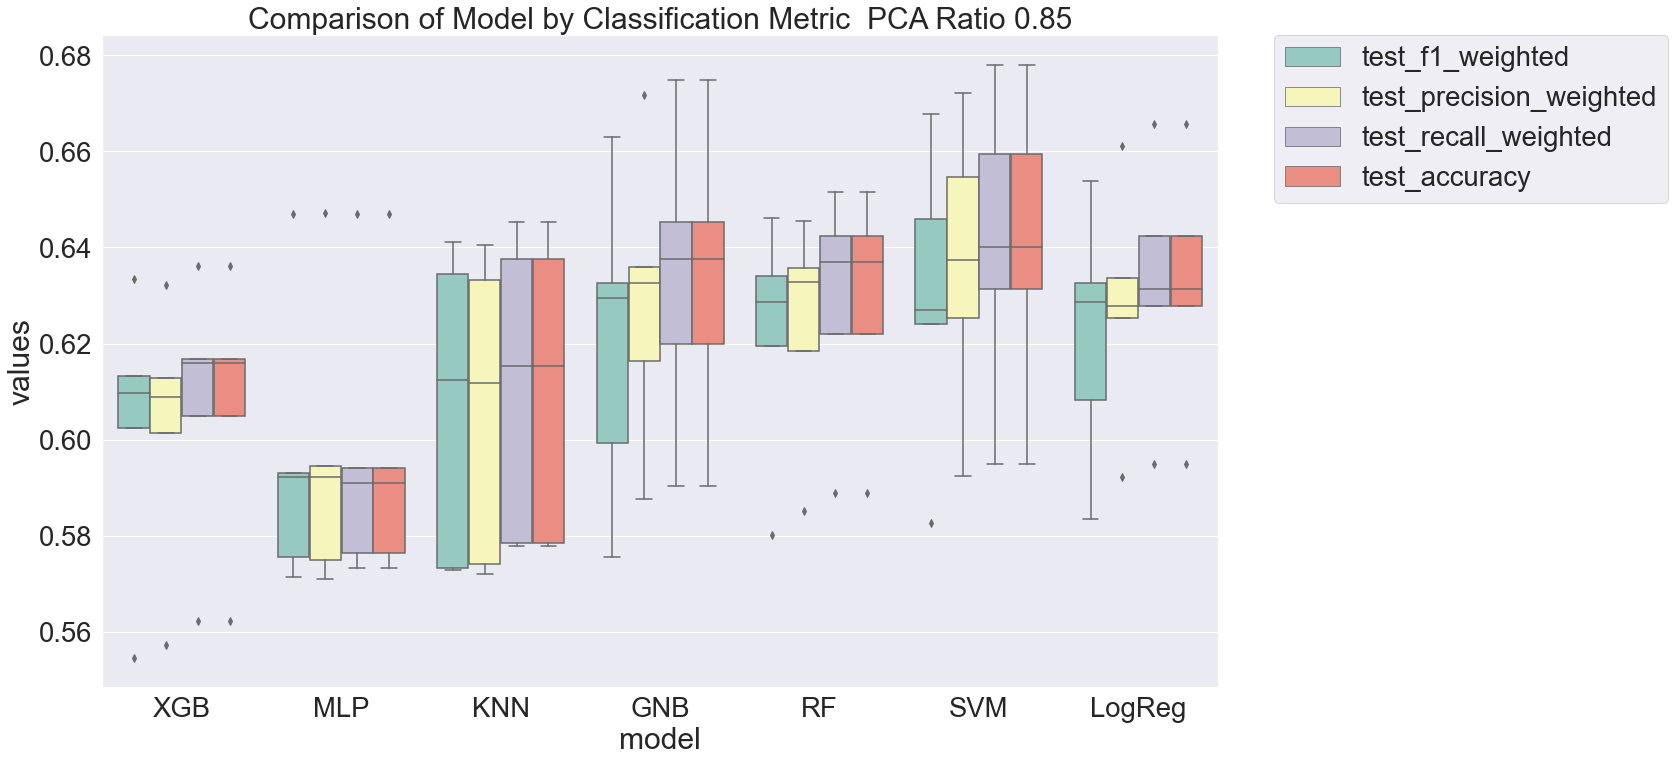

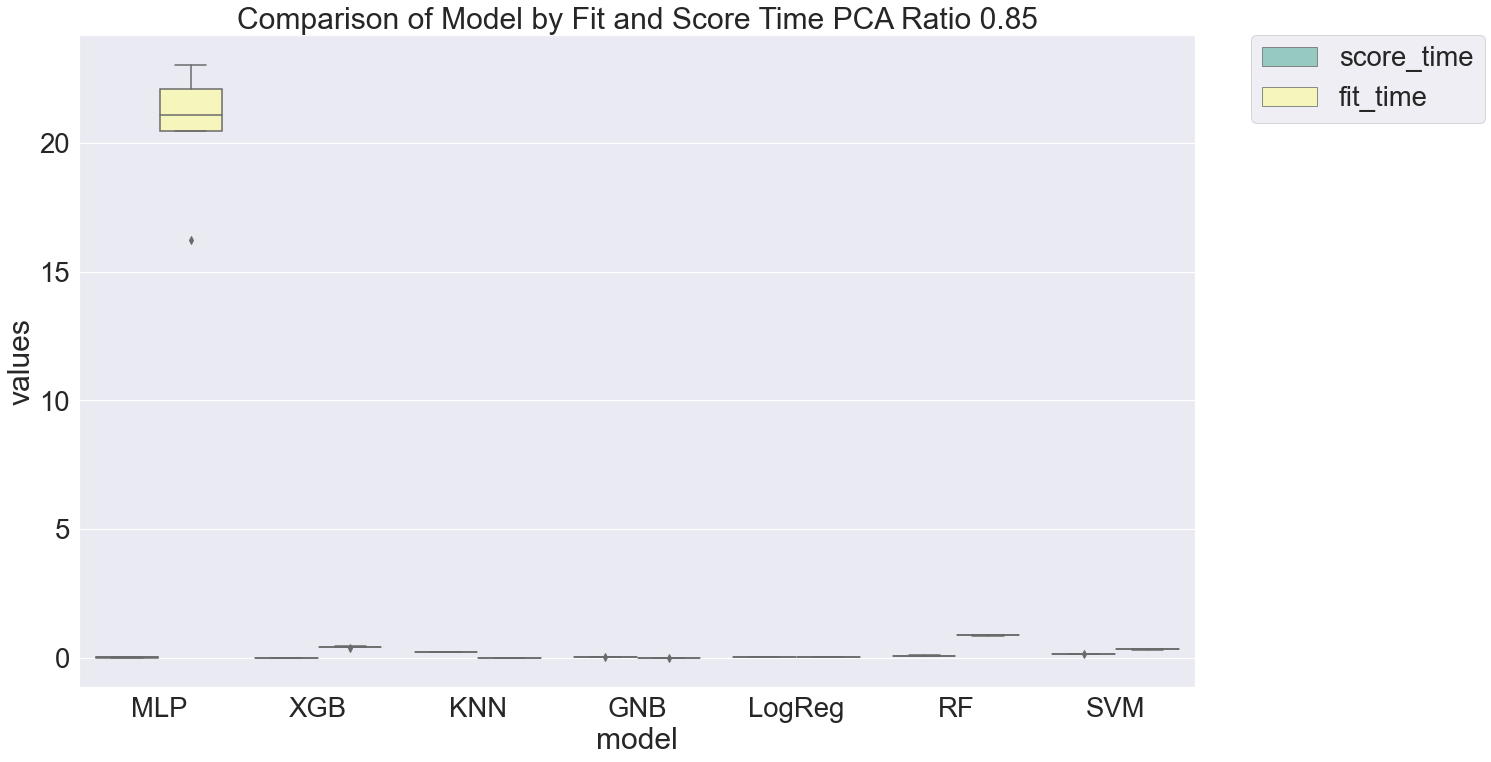

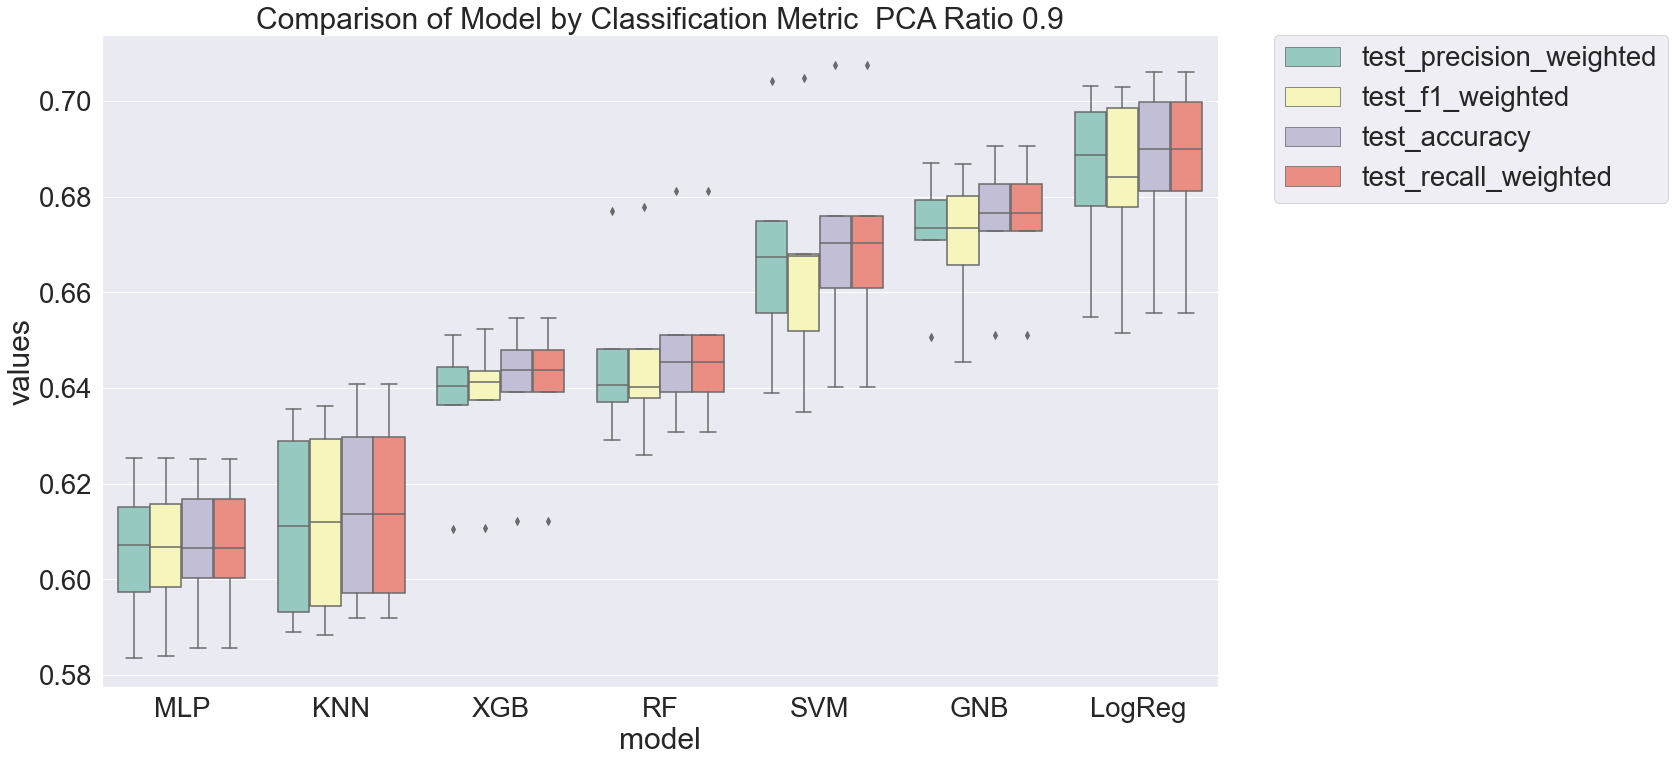

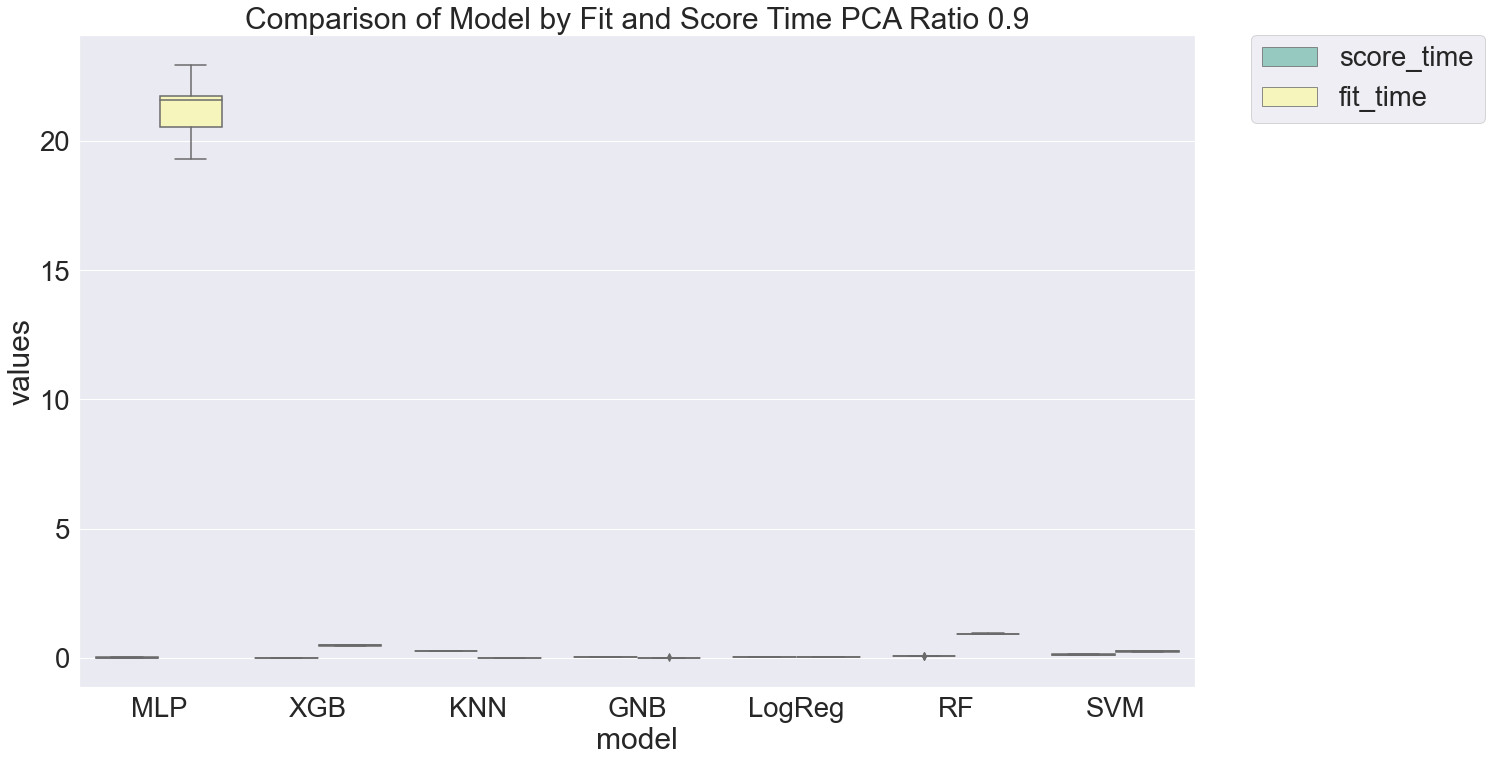

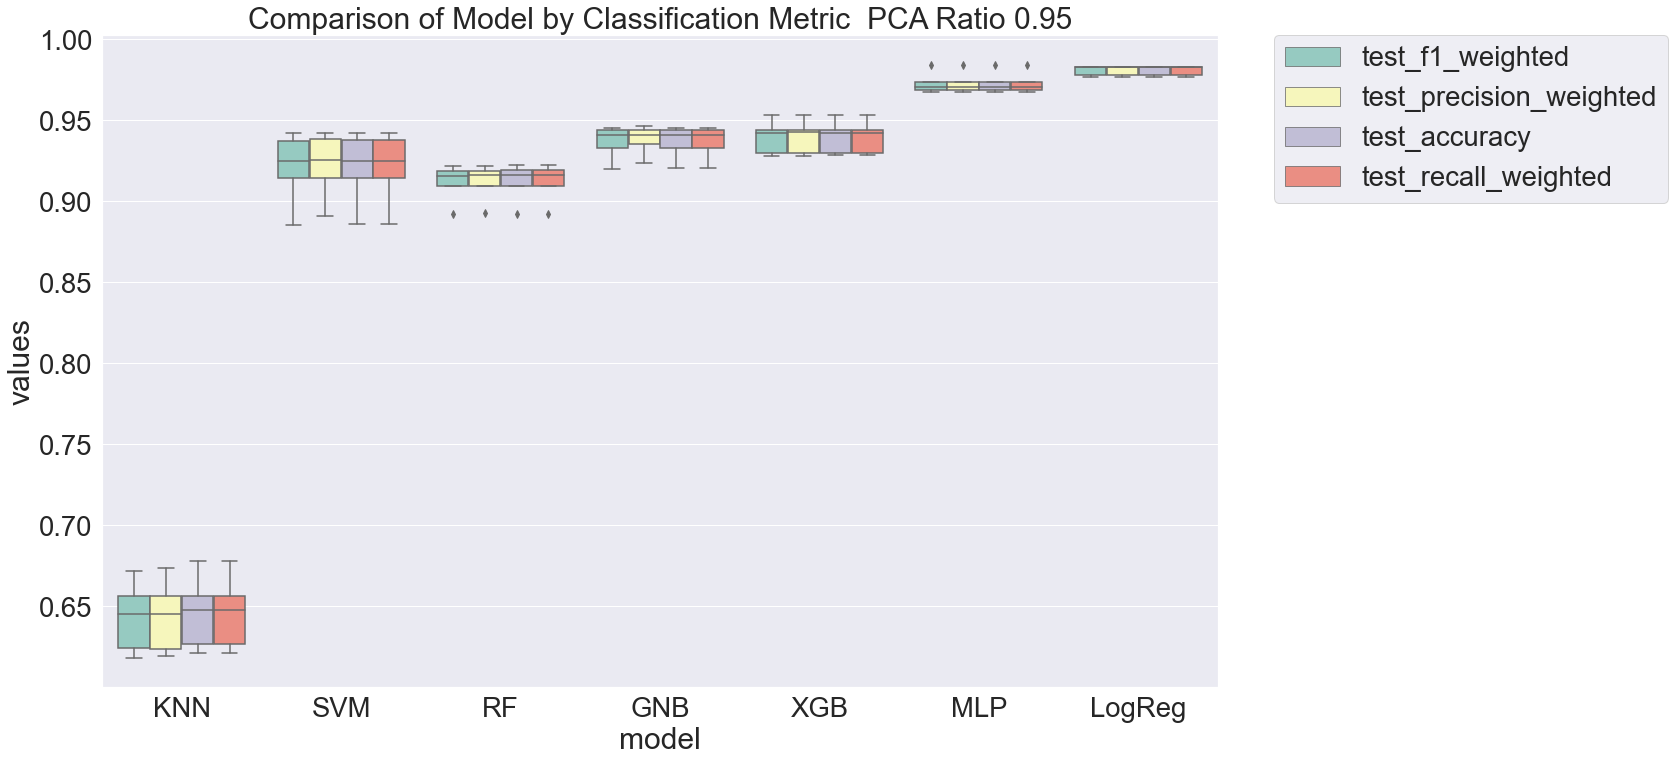

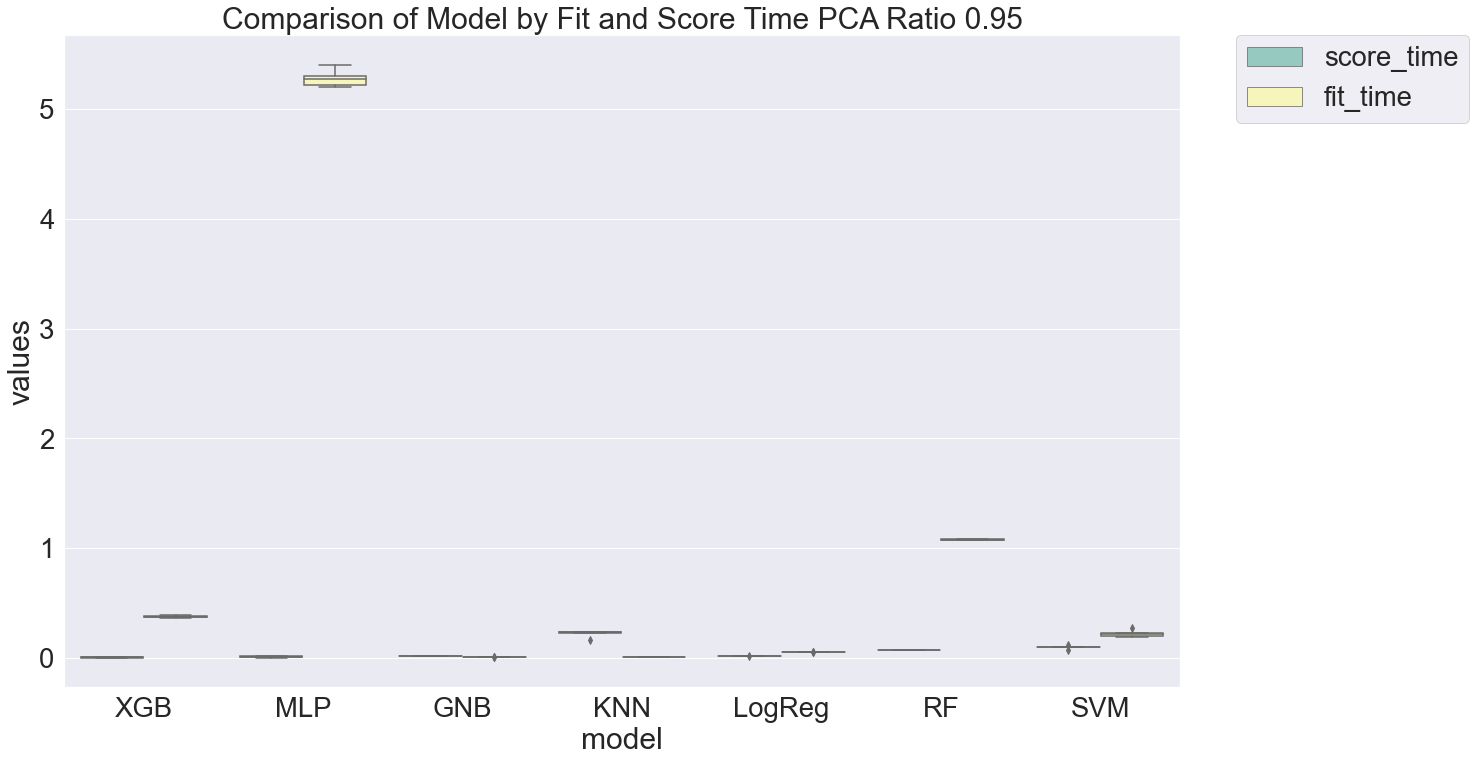

In [100]:
for i, (result, pca_ratio_used) in enumerate(results):  
    results_long_nofit, results_long_fit = evaluate_models(result)
    n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])  
    generate_plots(n_features, pca_ratio_used, results_long_nofit, results_long_fit)